In [3]:
#checking if I connected to a gpu instance lmao
!nvidia-smi

Sat Jul 15 05:10:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Installing dependencies for transformers,datasets,soundfile, speechbrain and lovely sweet compute accelerator 🚀

In [4]:
!pip install transformers datasets soundfile speechbrain accelerate

In [7]:
from huggingface_hub import notebook_login

notebook_login()

In [6]:
!git config --global credential.helper store

The dataset
For this example we’ll take the Dutch (nl) language subset of the VoxPopuli dataset. VoxPopuli is a large-scale multilingual speech corpus consisting of data sourced from 2009-2020 European Parliament event recordings. It contains labelled audio-transcription data for 15 European languages.

This is an automated speech recognition (ASR) dataset, so, as mentioned before, it is not the most suitable option for training TTS models. However, it will be good enough for this exercise.

Let’s load the data:

In [8]:
from datasets import load_dataset, Audio

dataset = load_dataset("facebook/voxpopuli", "nl", split="train")
len(dataset)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset voxpopuli downloaded and prepared to /root/.cache/huggingface/datasets/facebook___voxpopuli/nl/1.3.0/b5ff837284f0778eefe0f642734e142d8c3f574eba8c9c8a4b13602297f73604. Subsequent calls will reuse this data.


20968

In [9]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

Preprocessing the data
Let’s begin by defining the model checkpoint to use and loading the appropriate processor that contains both tokenizer, and feature extractor that we will need to prepare the data for training:

In [10]:
from transformers import SpeechT5Processor

checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)

Text cleanup for SpeechT5 tokenization
First, for preparing the text, we’ll need the tokenizer part of the processor, so let’s get it:

In [11]:
tokenizer = processor.tokenizer

In [12]:
dataset[0]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


{'audio_id': '20100210-0900-PLENARY-3-nl_20100210-09:06:43_4',
 'language': 9,
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/02ec6a19d5b97c03e1379250378454dbf3fa2972943504a91c7da5045aa26a89/train_part_0/20100210-0900-PLENARY-3-nl_20100210-09:06:43_4.wav',
  'array': array([ 4.27246094e-04,  1.31225586e-03,  1.03759766e-03, ...,
         -9.15527344e-05,  7.62939453e-04, -2.44140625e-04]),
  'sampling_rate': 16000},
 'raw_text': 'Dat kan naar mijn gevoel alleen met een brede meerderheid die wij samen zoeken.',
 'normalized_text': 'dat kan naar mijn gevoel alleen met een brede meerderheid die wij samen zoeken.',
 'gender': 'female',
 'speaker_id': '1122',
 'is_gold_transcript': True,
 'accent': 'None'}

The dataset examples contain raw_text and normalized_text features. When deciding which feature to use as the text input, it will be important to know that the SpeechT5 tokenizer doesn’t have any tokens for numbers. In normalized_text the numbers are written out as text. Thus, it is a better fit, and we should use normalized_text as input text.

Because SpeechT5 was trained on the English language, it may not recognize certain characters in the Dutch dataset. If left as is, these characters will be converted to <unk> tokens. However, in Dutch, certain characters like à are used to stress syllables. In order to preserve the meaning of the text, we can replace this character with a regular a.

To identify unsupported tokens, extract all unique characters in the dataset using the SpeechT5Tokenizer which works with characters as tokens. To do this, we’ll write the extract_all_chars mapping function that concatenates the transcriptions from all examples into one string and converts it to a set of characters.We make sure to set batched=True and batch_size=-1 in dataset.map() so that all transcriptions are available at once for the mapping function.

In [13]:
def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}


vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

  0%|          | 0/1 [00:00<?, ?ba/s]

Now you have two sets of characters: one with the vocabulary from the dataset and one with the vocabulary from the tokenizer. To identify any unsupported characters in the dataset, you can take the difference between these two sets. The resulting set will contain the characters that are in the dataset but not in the tokenizer

In [14]:
dataset_vocab - tokenizer_vocab

{' ', 'à', 'ç', 'è', 'ë', 'í', 'ï', 'ö', 'ü'}

In [15]:
replacements = [
    ("à", "a"),
    ("ç", "c"),
    ("è", "e"),
    ("ë", "e"),
    ("í", "i"),
    ("ï", "i"),
    ("ö", "o"),
    ("ü", "u"),
]


def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["normalized_text"] = inputs["normalized_text"].replace(src, dst)
    return inputs


dataset = dataset.map(cleanup_text)

  0%|          | 0/20968 [00:00<?, ?ex/s]

Speakers


The VoxPopuli dataset includes speech from multiple speakers, but how many speakers are represented in the dataset? To determine this, we can count the number of unique speakers and the number of examples each speaker contributes to the dataset. With a total of 20,968 examples in the dataset, this information will give us a better understanding of the distribution of speakers and examples in the data.

In [16]:
from collections import defaultdict

speaker_counts = defaultdict(int)

for speaker_id in dataset["speaker_id"]:
    speaker_counts[speaker_id] += 1

By plotting a histogram you can get a sense of how much data there is for each speaker.

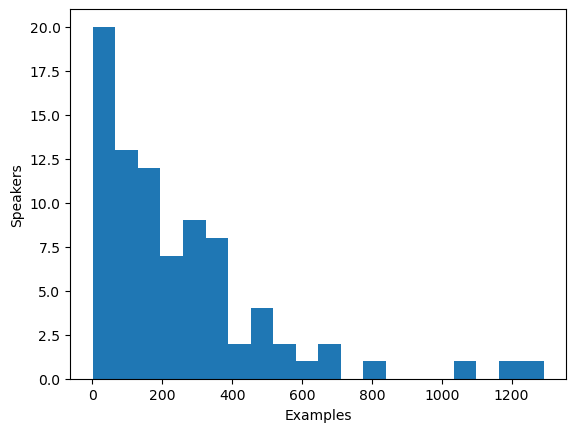

In [17]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

The histogram reveals that approximately one-third of the speakers in the dataset have fewer than 100 examples, while around ten speakers have more than 500 examples. To improve training efficiency and balance the dataset, we can limit the data to speakers with between 100 and 400 examples.

In [18]:
def select_speaker(speaker_id):
    return 100 <= speaker_counts[speaker_id] <= 400


dataset = dataset.filter(select_speaker, input_columns=["speaker_id"])

  0%|          | 0/21 [00:00<?, ?ba/s]

Checking no of speakers


In [19]:
len(set(dataset["speaker_id"]))

42

Checking the examples left in the dataset

In [20]:
len(dataset)

9973

We are left with just under 10,000 examples from approximately 40 unique speakers, which should be sufficient.

Some speakers with few examples may actually have more audio available if the examples are long. However, determining the total amount of audio for each speaker requires scanning through the entire dataset, which is a time-consuming process that involves loading and decoding each audio file. As such, we have chosen to skip this step here.

Speaker embeddings

To enable the TTS model to differentiate between multiple speakers, you’ll need to create a speaker embedding for each example. The speaker embedding is an additional input into the model that captures a particular speaker’s voice characteristics. To generate these speaker embeddings, use the [pre-trained spkrec-xvect-voxceleb model](https://huggingface.co/speechbrain/spkrec-xvect-voxceleb)  from SpeechBrain.

We create a function create_speaker_embedding() that takes an input audio waveform and outputs a 512-element vector containing the corresponding speaker embedding.

In [21]:
import os
import torch
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)


def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

It’s important to note that the speechbrain/spkrec-xvect-voxceleb model was trained on English speech from the VoxCeleb dataset, whereas the training examples in this guide are in Dutch. While we believe that this model will still generate reasonable speaker embeddings for our Dutch dataset, this assumption may not hold true in all cases.

For optimal results, we would need to train an X-vector model on the target speech first. This will ensure that the model is better able to capture the unique voice characteristics present in the Dutch language. If you’d like to train your own X-vector model, you can use [this script](https://huggingface.co/mechanicalsea/speecht5-vc/blob/main/manifest/utils/prep_cmu_arctic_spkemb.py) as an example.

Processing the dataset

Finally, let’s process the data into the format the model expects. Create a prepare_dataset function that takes in a single example and uses the SpeechT5Processor object to tokenize the input text and load the target audio into a log-mel spectrogram. It should also add the speaker embeddings as an additional input.

In [22]:
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        text=example["normalized_text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

Verifying the processing is correct 

In [23]:
processed_example = prepare_dataset(dataset[0])
list(processed_example.keys())

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

['input_ids', 'labels', 'speaker_embeddings']

Speaker embeddings should be a 512-element vector:

In [24]:
processed_example["speaker_embeddings"].shape

(512,)

The labels we get is a log-mel spectrogram with 80 mel bins.


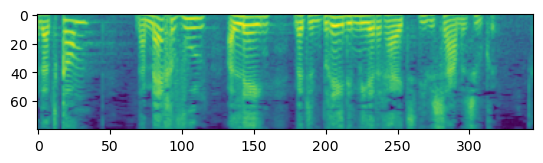

In [25]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

This spectrogram is upside down and might seem confusing because we are used to generally seeing low frequencies at the bottom and high frequencies at the top of a lot. However, when plotting spectrograms as an image using the matplotlib library, the y-axis is flipped and the spectrogram appear upside down.

Now we need to apply the processing function the entire dataset. This will take between 5 and 10 minutes

In [ ]:
dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names)

  0%|          | 0/9973 [00:00<?, ?ex/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (614 > 600). Running this sequence through the model will result in indexing errors


We saw a warning saying that some examples in the dataset are longer than the maximum input length the model can handle (600 tokens). Remove those examples from the dataset. Here we go even further and to allow for larger batch sizes we remove anything over 200 tokens.

In [ ]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200


dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])
len(dataset)

We create another basic train/test split:

In [ ]:
dataset = dataset.train_test_split(test_size=0.1)

Data collator

In order to combine multiple examples into a batch, we need to define a custom data collator. This collator will pad shorter sequences with padding tokens, ensuring that all examples have the same length. For the spectrogram labels, the padded portions are replaced with the special value -100. This special value instructs the model to ignore that part of the spectrogram when calculating the spectrogram loss.

In [ ]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids, labels=label_features, return_tensors="pt"
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor(
                [len(feature["input_values"]) for feature in label_features]
            )
            target_lengths = target_lengths.new(
                [
                    length - length % model.config.reduction_factor
                    for length in target_lengths
                ]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In SpeechT5, the input to the decoder part of the model is reduced by a factor 2. In other words, it throws away every other timestep from the target sequence. The decoder then predicts a sequence that is twice as long. Since the original target sequence length may be odd, the data collator makes sure to round the maximum length of the batch down to be a multiple of 2.

In [ ]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

Train the model

Load the pre-trained model from the same checkpoint as you used for loading the processor:

In [ ]:
from transformers import SpeechT5ForTextToSpeech

model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)

The use_cache=True option is incompatible with gradient checkpointing. Disable it for training, and re-enable cache for generation to speed-up inference time:

In [ ]:
from functools import partial

# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(model.generate, use_cache=True)

We define the training arguments. Here we are not computing any evaluation metrics during the training process. I would implement that differently in a notebook. Instead, we’ll only look at the loss:

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="speecht5_finetuned_voxpopuli_Nederlands",  # change to a repo name of choice
    per_device_train_batch_size=8,
    gradient_accumulation_steps=16,
    learning_rate=1e-5,
    warmup_steps=50,
    max_steps=500,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=2,
    save_steps=100,
    eval_steps=100,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True,
)

We instantiate the Trainer object and pass the model, dataset, and data collator to it.

In [34]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

And with that, we’re ready to start training! Training will take several hours. Depending on the  GPU, it is possible that you will encounter a CUDA “out-of-memory” error when you start training. In this case, you can reduce the per_device_train_batch_size incrementally by factors of 2 and increase gradient_accumulation_steps by 2x to compensate.
This notebook was ran on a kaggle notebook with two Nvidia T4 15 GBs so I had a total VRAM of 30GBs.

In [35]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
100,0.626600,0.544784
200,0.553300,0.504041
300,0.540100,0.492991
400,0.535000,0.489822
500,0.533100,0.488815


TrainOutput(global_step=500, training_loss=0.5790679473876953, metrics={'train_runtime': 5647.1328, 'train_samples_per_second': 11.333, 'train_steps_per_second': 0.089, 'total_flos': 9473391339502464.0, 'train_loss': 0.5790679473876953, 'epoch': 8.6})

Push the final model to the 🤗 Hub:

In [36]:
trainer.push_to_hub()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/558M [00:00<?, ?B/s]

Upload file runs/Jul15_05-35-57_a82a87fa3845/events.out.tfevents.1689399539.a82a87fa3845.28.0:   0%|          …

To https://huggingface.co/Ryukijano/speecht5_finetuned_voxpopuli_Nederlands
   bbb8274..a59114e  main -> main

To https://huggingface.co/Ryukijano/speecht5_finetuned_voxpopuli_Nederlands
   a59114e..c4fa9a9  main -> main



'https://huggingface.co/Ryukijano/speecht5_finetuned_voxpopuli_Nederlands/commit/a59114e109ba20bfe2b47ea69ed0c8eeec6f18b6'